<a href="https://colab.research.google.com/github/Nichiel/rubbish_classifier/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall tensorflow
!pip install  tensorflow==2.1.0

In [ ]:
!pip install h5py==2.10.0 --force-reinstall

In [11]:
import tensorflow
tensorflow.__version__

'2.1.0'

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib

from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout


In [21]:
directory = 'drive/MyDrive/PHOTO_AU/'
folder_name = ['P','TP']
IMG_SIZE = (224,224)
batch_size = 32
base_learning_rate = 0.001
IMG_SHAPE = (224,224) + (3,)


In [22]:
def PhotoImport(folder_name):
  file_list = []
  for index in folder_name:
    imgdir_path = pathlib.Path(directory, index )
    last_list = sorted([str(path) for path in imgdir_path.glob('*.png')]) 
    file_list += last_list
  
  return file_list, [1 if 'TP' in file else 0 for file in file_list]

In [23]:
def load_and_preprocess(path, label):
    image = tf.io.read_file(path) 
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    
    return (image/255.0, tf.cast(label, tf.int32))

In [24]:
file_list, labels = PhotoImport(folder_name)
ds_files_labels = tf.data.Dataset.from_tensor_slices((file_list, labels))

ds_files_labels = ds_files_labels.shuffle(len(file_list), reshuffle_each_iteration=False)

bin_files_valid = ds_files_labels.take(673)
bin_files_train = ds_files_labels.skip(673)
ds_bin_train = bin_files_train.map(load_and_preprocess)
ds_bin_valid = bin_files_valid.map(load_and_preprocess)
ds_bin_train = ds_bin_train.batch(batch_size)
ds_bin_valid = ds_bin_valid.batch(batch_size)

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_bin_train = ds_bin_train.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
base_model = ResNet101V2(input_shape= IMG_SHAPE, include_top=True, weights='imagenet')


179519488/179518384 [==============================] - 2s 0us/step


In [27]:
transfer_layer = base_model.get_layer('avg_pool')
transfer_layer.output

conv_model = Model(inputs=base_model.input, outputs=transfer_layer.output)
new_model = Sequential()
new_model.add(conv_model)
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(1, activation='sigmoid'))


In [28]:
conv_model.trainable = True
for layer in conv_model.layers[:]:
    trainable_layer = ('conv5' in layer.name)
    layer.trainable = trainable_layer


In [29]:
loss_function=tf.keras.losses.BinaryCrossentropy( from_logits= True)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
metrics=['accuracy']
total_epochs =  15
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights = True)

new_model.compile(loss=loss_function, optimizer = optimizer,  metrics=metrics)

In [30]:
history = new_model.fit(x = ds_bin_train, 
                         epochs=total_epochs,
                         validation_data=ds_bin_valid, callbacks=[callback])

Train for 354 steps, validate for 22 steps
Epoch 1/15
354/354 [==============================] - 1640s 5s/step - loss: 0.5267 - accuracy: 0.9737 - val_loss: 0.5265 - val_accuracy: 0.9614
Epoch 2/15
354/354 [==============================] - 212s 598ms/step - loss: 0.5149 - accuracy: 0.9974 - val_loss: 0.5244 - val_accuracy: 0.9718
Epoch 3/15
354/354 [==============================] - 211s 597ms/step - loss: 0.5148 - accuracy: 0.9969 - val_loss: 0.5213 - val_accuracy: 0.9822
Epoch 4/15
354/354 [==============================] - 211s 595ms/step - loss: 0.5137 - accuracy: 0.9991 - val_loss: 0.5220 - val_accuracy: 0.9747
Epoch 5/15
354/354 [==============================] - 211s 595ms/step - loss: 0.5134 - accuracy: 0.9996 - val_loss: 0.5256 - val_accuracy: 0.9629
Epoch 6/15
354/354 [==============================] - 211s 595ms/step - loss: 0.5143 - accuracy: 0.9976 - val_loss: 0.5382 - val_accuracy: 0.9316
Epoch 7/15
354/354 [==============================] - 211s 596ms/step - loss: 0.514

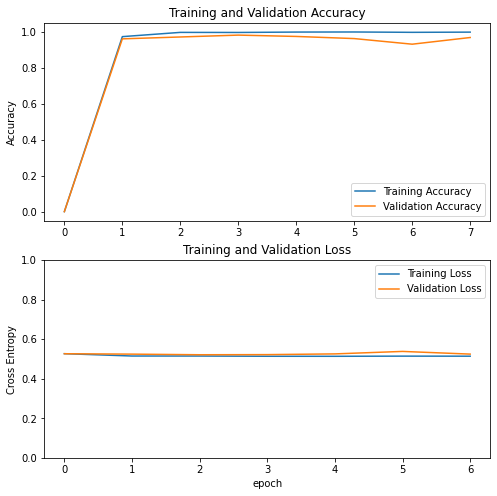

In [31]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.05])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
new_model.save( 'drive/MyDrive/rubbish_classifier_model_A_0001.h5', overwrite = True, include_optimizer = True, save_format = 'h5')